## Analysis of Airbnb data from Munich, Germany

Plese see also my blog post on Medium and the corresponding Kernel on Kaggle.  
The data set can also be found here: https://www.kaggle.com/chriskue/munich-airbnb-data

An associated blog post can be found on Kaggle https://www.kaggle.com/chriskue/airbnb-analysis-munich and on Medium (link tbd.)


In [1]:
# Import all the libraries which will be needed later
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
# Load the dataset 
df_calendar = pd.read_csv("./calendar.zip", low_memory = False); # contains calendar.csv
df_listings = pd.read_csv("./listings.zip", low_memory = False); # contains listings.csv
df_reviews = pd.read_csv("./reviews.zip", low_memory = False); # contains reviews.csv

........................

### Business Understanding

**In order to get a better insight into Airbnb, especially in Munich, I am particularly interested in the following three questions:**  
1. When is the most expensive time of the year to visit Munich and how much does the price spike?
2. What are the most expensive neighbourhoods in Munich? 
3. What factors influence the price most? 

........................

### Data Understanding - Analyse the data for a better understanding and to check the quality of the data

**Check the data set "calendar.csv"**

In [3]:
# Take a look at a concise summary of the DataFrame 'calendar'
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190565 entries, 0 to 4190564
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: int64(3), object(4)
memory usage: 223.8+ MB


In [4]:
# Show the first 5 rows of the data set
df_calendar.head(5)

listing_id        date available    price adjusted_price  minimum_nights  \
0      216529  2019-11-25         f  $150.00        $150.00               5   
1      159634  2019-11-25         f   $53.00         $53.00              14   
2      159634  2019-11-26         f   $53.00         $53.00              14   
3      159634  2019-11-27         f   $53.00         $53.00              14   
4      159634  2019-11-28         f   $53.00         $53.00              14   

   maximum_nights  
0              60  
1              90  
2              90  
3              90  
4              90

In [5]:
# List all features in this data set and show the number of missing values
obj = df_calendar.isnull().sum()
for key,value in obj.iteritems():
    percent = round((value * 100 / df_calendar['listing_id'].index.size),3)
    print(key,", ",value, "(", percent ,"%)")

listing_id ,  0 ( 0.0 %)
date ,  0 ( 0.0 %)
available ,  0 ( 0.0 %)
price ,  171 ( 0.004 %)
adjusted_price ,  171 ( 0.004 %)
minimum_nights ,  0 ( 0.0 %)
maximum_nights ,  0 ( 0.0 %)


**Summary after analysing the dataset "calendar"**  
The data set consists of 7 features and a total rows of 4.190.565.  
The overall quality is good, only the features 'price' and 'adjusted_price' have missing data (171).

For further analysis the follwing data cleaning is required:
1. Drop feature 'adjusted_price'.
2. Remove the rows with missing data in 'price' (number of affected rows is low ~0.004%).
3. The feature 'price' needs to be converted to numerical value
4. The feature 'date' needs to be converted to datetime format
5. The feature 'available' needs to be converted into boolean data type

**Check the data set "listings.csv"**

In [6]:
# Take a look at a concise summary of the DataFrame 'listings'
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11481 entries, 0 to 11480
Columns: 106 entries, id to reviews_per_month
dtypes: float64(24), int64(21), object(61)
memory usage: 9.3+ MB


In [7]:
# Show the first 5 rows of the data set
df_listings.head(5)

id                          listing_url       scrape_id last_scraped  \
0   36720   https://www.airbnb.com/rooms/36720  20191125094942   2019-11-25   
1   97945   https://www.airbnb.com/rooms/97945  20191125094942   2019-11-25   
2  114695  https://www.airbnb.com/rooms/114695  20191125094942   2019-11-25   
3  127383  https://www.airbnb.com/rooms/127383  20191125094942   2019-11-25   
4  157808  https://www.airbnb.com/rooms/157808  20191125094942   2019-11-25   

                                  name  \
0  Beautiful 2 rooms flat, Glockenbach   
1     Deluxw-Apartm. with roof terrace   
2   Apartment Munich/East with sundeck   
3    City apartment next to Pinakothek   
4          Near Olympia,English Garden   

                                             summary  \
0  Very quiet, yet centrally located 2 rooms apt....   
1                                                NaN   
2                                                NaN   
3  Die Wohnung hat 55 qm und ist voll ausgestatte...   
4  Kleines gemütliches Privat Zimmer mit Kabel TV...   

                                               space  \
0  2-Zimmer Altbauwohung Beste Lage, zentral, im ...   
1  We offer a modern, quiet apartment with a sunn...   
2  It´s a quiet and sunny apartment close to the ...   
3  My cosy apartment is located in the heart of M...   
4  Kleines gemütliches Privat Zimmer ca.14qm möbl...   

                                         description experiences_offered  \
0  Very quiet, yet centrally located 2 rooms apt....                none   
1  We offer a modern, quiet apartment with a sunn...                none   
2  It´s a quiet and sunny apartment close to the ...                none   
3  My cosy apartment is located in the heart of M...                none   
4  Kleines gemütliches Privat Zimmer ca.14qm möbl...                none   

                               neighborhood_overview        ...          \
0  Glockenbachviertel area has the hippest restau...        ...           
1  We are living in a outskirt of Munich its call...        ...           
2                                                NaN        ...           
3                                                NaN        ...           
4  In der Nähe befinden sich einige Kaffees,Kneip...        ...           

  instant_bookable is_business_travel_ready          cancellation_policy  \
0                f                        f  strict_14_with_grace_period   
1                f                        f                     flexible   
2                f                        f  strict_14_with_grace_period   
3                f                        f                     flexible   
4                f                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             t                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               1   
1                               1   
2                               2   
3                               2   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            1   
2                                            2   
3                                            1   
4                                            0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
3                                            1   
4                                            1   

   cal

In [8]:
# List all features in this data set and show the number of missing values
obj = df_listings.isnull().sum()
for key,value in obj.iteritems():
    percent = round((value * 100 / df_listings['id'].index.size),3)
    print(key,", ",value, "(", percent ,"%)")

id ,  0 ( 0.0 %)
listing_url ,  0 ( 0.0 %)
scrape_id ,  0 ( 0.0 %)
last_scraped ,  0 ( 0.0 %)
name ,  22 ( 0.192 %)
summary ,  618 ( 5.383 %)
space ,  4284 ( 37.314 %)
description ,  303 ( 2.639 %)
experiences_offered ,  0 ( 0.0 %)
neighborhood_overview ,  5330 ( 46.425 %)
notes ,  8152 ( 71.004 %)
transit ,  4342 ( 37.819 %)
access ,  6420 ( 55.918 %)
interaction ,  5655 ( 49.255 %)
house_rules ,  5926 ( 51.616 %)
thumbnail_url ,  11481 ( 100.0 %)
medium_url ,  11481 ( 100.0 %)
picture_url ,  0 ( 0.0 %)
xl_picture_url ,  11481 ( 100.0 %)
host_id ,  0 ( 0.0 %)
host_url ,  0 ( 0.0 %)
host_name ,  23 ( 0.2 %)
host_since ,  23 ( 0.2 %)
host_location ,  70 ( 0.61 %)
host_about ,  6470 ( 56.354 %)
host_response_time ,  5104 ( 44.456 %)
host_response_rate ,  5104 ( 44.456 %)
host_acceptance_rate ,  11481 ( 100.0 %)
host_is_superhost ,  23 ( 0.2 %)
host_thumbnail_url ,  23 ( 0.2 %)
host_picture_url ,  23 ( 0.2 %)
host_neighbourhood ,  2742 ( 23.883 %)
host_listings_count ,  23 ( 0.2 %)
host_t

In [9]:
# Count distinct observations per feature
df_listings.nunique()

id                                              11481
listing_url                                     11481
scrape_id                                           1
last_scraped                                        2
name                                            11172
summary                                         10495
space                                            6861
description                                     10930
experiences_offered                                 1
neighborhood_overview                            5595
notes                                            3075
transit                                          6664
access                                           4554
interaction                                      5178
house_rules                                      4981
thumbnail_url                                       0
medium_url                                          0
picture_url                                     11229
xl_picture_url              

**Summary after analysing the dataset "listings"**  
The dataset consists of 106 features and a total rows of 11.481.  
The overall quality is not for all features good. It must be considered how to deal with the remaining missing values. Filling does not look very promising in all cases, so the features should be droped from a threshold.
Some features have only constant values and don't help us any further.

For further analysis the follwing data cleaning is required:  
1. Drop features with constant values 
2. Drop features with more than 50% missing data
3. Fill missing numerical data with mean value
4. Convert features to useable data type (e.g. price)
5. Drop features that do not provide us with any useful information (for our specific questions)  

Consider whether the outliers in feature 'price' should be dropped.

**Check the data set "reviews.csv"**

In [10]:
# Take a look at a concise summary of the DataFrame 'reviews'
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175562 entries, 0 to 175561
Data columns (total 6 columns):
listing_id       175562 non-null int64
id               175562 non-null int64
date             175562 non-null object
reviewer_id      175562 non-null int64
reviewer_name    175562 non-null object
comments         175488 non-null object
dtypes: int64(3), object(3)
memory usage: 8.0+ MB


In [11]:
# Show the first 5 rows of the data set
df_reviews.head(5)

id                          listing_url       scrape_id last_scraped  \
0   36720   https://www.airbnb.com/rooms/36720  20191125094942   2019-11-25   
1   97945   https://www.airbnb.com/rooms/97945  20191125094942   2019-11-25   
2  114695  https://www.airbnb.com/rooms/114695  20191125094942   2019-11-25   
3  127383  https://www.airbnb.com/rooms/127383  20191125094942   2019-11-25   
4  157808  https://www.airbnb.com/rooms/157808  20191125094942   2019-11-25   

                                  name  \
0  Beautiful 2 rooms flat, Glockenbach   
1     Deluxw-Apartm. with roof terrace   
2   Apartment Munich/East with sundeck   
3    City apartment next to Pinakothek   
4          Near Olympia,English Garden   

                                             summary  \
0  Very quiet, yet centrally located 2 rooms apt....   
1                                                NaN   
2                                                NaN   
3  Die Wohnung hat 55 qm und ist voll ausgestatte...   
4  Kleines gemütliches Privat Zimmer mit Kabel TV...   

                                               space  \
0  2-Zimmer Altbauwohung Beste Lage, zentral, im ...   
1  We offer a modern, quiet apartment with a sunn...   
2  It´s a quiet and sunny apartment close to the ...   
3  My cosy apartment is located in the heart of M...   
4  Kleines gemütliches Privat Zimmer ca.14qm möbl...   

                                         description experiences_offered  \
0  Very quiet, yet centrally located 2 rooms apt....                none   
1  We offer a modern, quiet apartment with a sunn...                none   
2  It´s a quiet and sunny apartment close to the ...                none   
3  My cosy apartment is located in the heart of M...                none   
4  Kleines gemütliches Privat Zimmer ca.14qm möbl...                none   

                               neighborhood_overview        ...          \
0  Glockenbachviertel area has the hippest restau...        ...           
1  We are living in a outskirt of Munich its call...        ...           
2                                                NaN        ...           
3                                                NaN        ...           
4  In der Nähe befinden sich einige Kaffees,Kneip...        ...           

  instant_bookable is_business_travel_ready          cancellation_policy  \
0                f                        f  strict_14_with_grace_period   
1                f                        f                     flexible   
2                f                        f  strict_14_with_grace_period   
3                f                        f                     flexible   
4                f                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             t                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               1   
1                               1   
2                               2   
3                               2   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            1   
2                                            2   
3                                            1   
4                                            0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
3                                            1   
4                                            1   

   cal

In [12]:
# List all features in this data set and show the number of missing values
obj = df_reviews.isnull().sum()
for key,value in obj.iteritems():
    percent = round((value * 100 / df_reviews['id'].index.size),3)
    print(key,", ",value, "(", percent ,"%)")

listing_id ,  0 ( 0.0 %)
id ,  0 ( 0.0 %)
date ,  0 ( 0.0 %)
reviewer_id ,  0 ( 0.0 %)
reviewer_name ,  0 ( 0.0 %)
comments ,  74 ( 0.042 %)


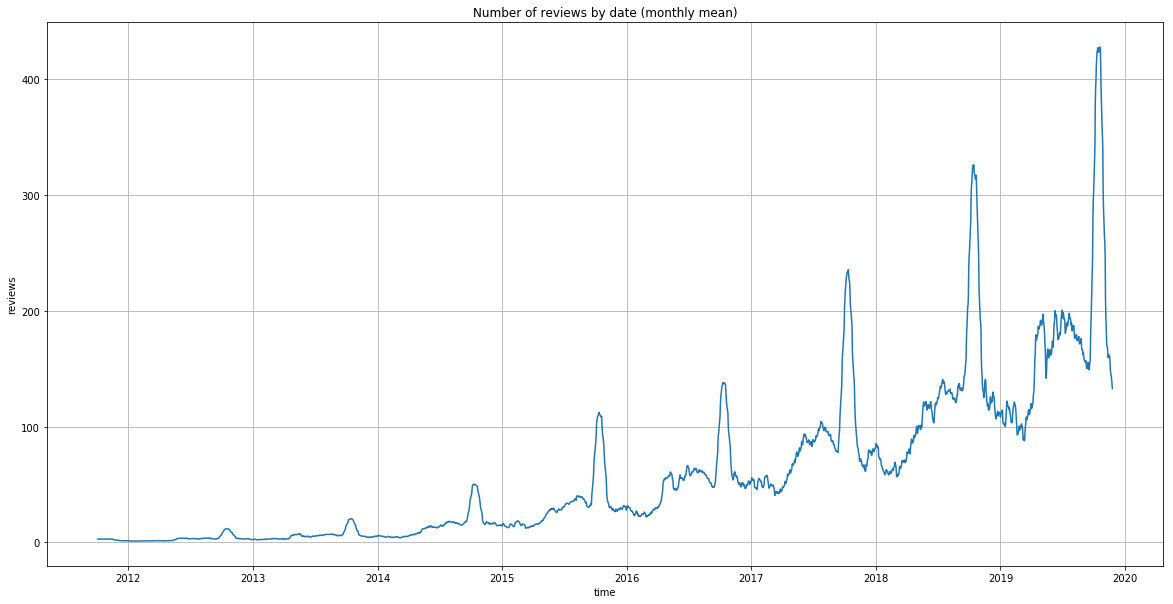

In [13]:
# Plot the number reviews over time to see any patterns
df_reviews_plot = df_reviews.groupby('date')['id'].count().reset_index()
df_reviews_plot["rolling_mean"] = df_reviews_plot.id.rolling(window=30).mean()
df_reviews_plot['date'] = pd.to_datetime(df_reviews_plot['date'])

plt.figure(figsize=(20, 10));
plt.plot(df_reviews_plot.date, df_reviews_plot.rolling_mean);

plt.title("Number of reviews by date (monthly mean)");
plt.xlabel("time");
plt.ylabel("reviews");
plt.grid()

**Summary after analysing the dataset "reviews"**  
The dataset consists of 6 features and a total of 175.561 rows.   
The overall quality is good, only the feature 'comments' has missing data (74).  
At first sight the data set cannot be used to answer the questions. Nonetheless, the number of reviews shows an interesting pattern which should also be examined. 
Maybe the feature 'id' can be connected to the other data sets 'calendar' or 'listings'. 
If I used the data set for my further analysis, I would drop missing data in 'comments' (number of affected rows is low ~0.04%) and convert the feature 'date' in to the 'DateTime' data type.

........................

### Data preparation - Create the data sets used for the further analyzes

**Preparation for Question 1: "When is the most expensive time of the year to visit Munich and how much do the price spike?"**

In [14]:
# Copy the data to a new DataFrame for further clean up
df_calendar_clean = df_calendar.copy(deep=True)

In [15]:
# Clean up the data set "calendar" as the previous analysis pointed out

# Drop "adjusted_price"
df_calendar_clean = df_calendar_clean.drop("adjusted_price", axis = 1)

# Remove missing values
df_calendar_clean.dropna(how='all', inplace=True)

# Convert the data type of feature 'date' from object to DateTime
df_calendar_clean['date'] = pd.to_datetime(df_calendar_clean['date'])

# clean up the format of the 'price' values. Maybe not the best solution - but will do the job
df_calendar_clean['price'] = df_calendar_clean['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Convert the feature 'available' to boolean data type
# (This conversion is actually not necessary for further analysis)
df_calendar_clean['available'] = df_calendar_clean['available'].replace({'t': True, 'f':False})

In [16]:
# Group the data by mean price per date
df_calendar_clean = df_calendar_clean.groupby('date')['price'].mean().reset_index()

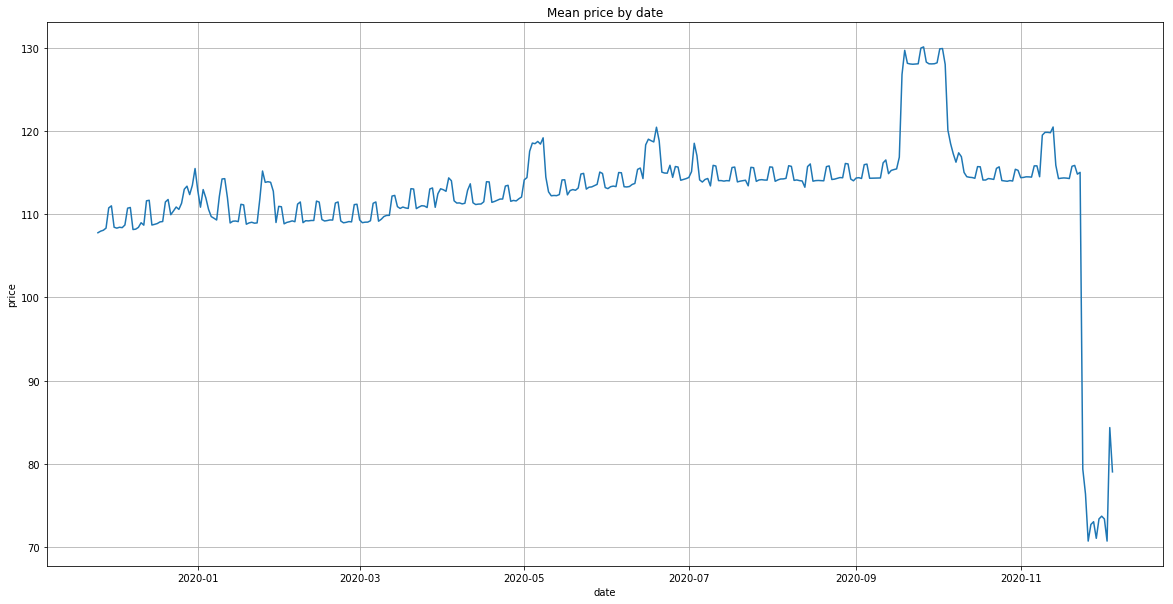

In [17]:
# Plot the mean price over time
plt.figure(figsize=(20, 10));
plt.plot(df_calendar_clean.date, df_calendar_clean.price);

plt.title("Mean price by date");
plt.xlabel("date");
plt.ylabel("price");
plt.grid();

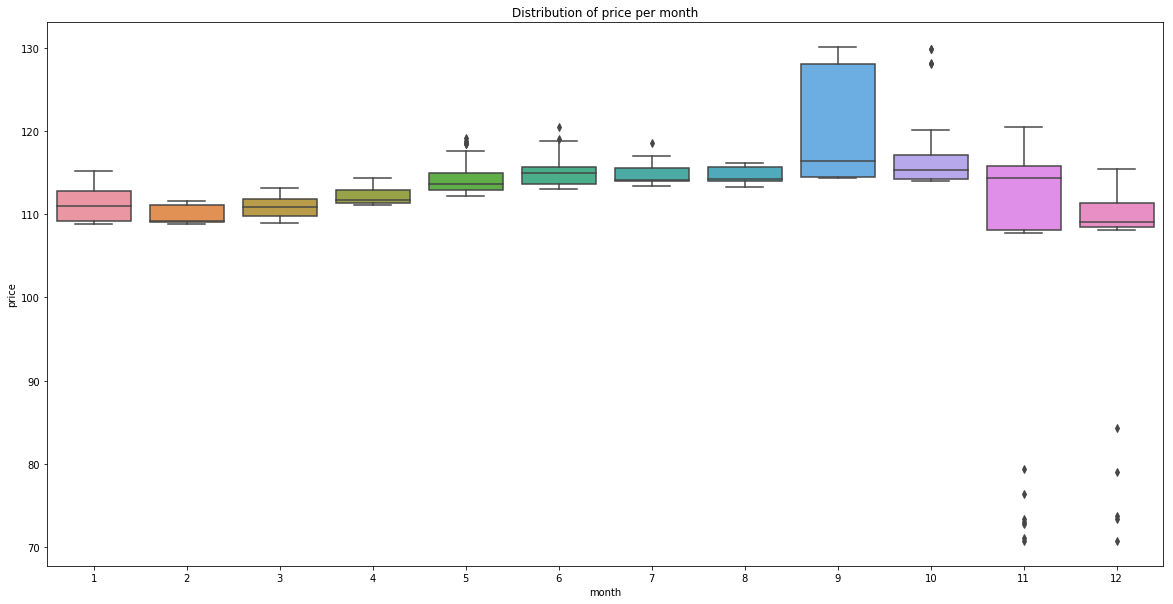

In [18]:
# Create a new feature 'month'
df_calendar_clean["month"] = df_calendar_clean["date"].dt.month

# Show a Boxplot to see the price distribution per month
plt.figure(figsize=(20, 10))
boxplot = sns.boxplot(x = 'month',  y = 'price', data 
                      = df_calendar_clean).set_title('Distribution of price per month');

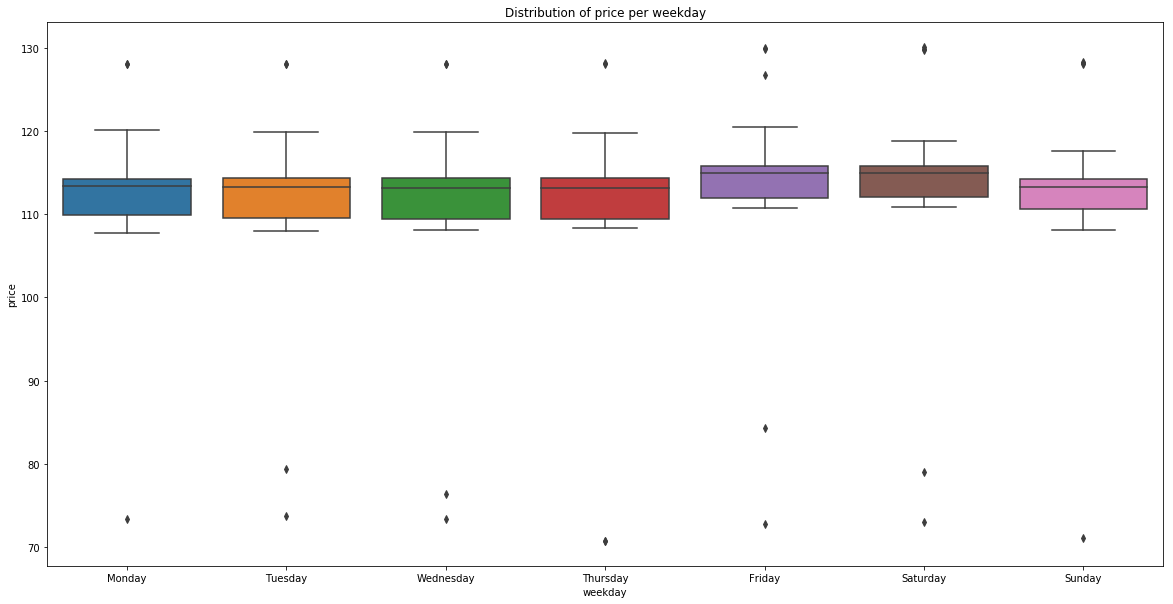

In [19]:
# Create a new feature 'weekday'
df_calendar_clean["weekday"] = df_calendar_clean["date"].dt.weekday_name

# Show a Boxplot to see the price distribution per weekday
plt.figure(figsize=(20, 10))
sns.boxplot(x = 'weekday',  y = 'price', data 
            = df_calendar_clean).set_title('Distribution of price per weekday');

In [20]:
# Show the statistics per weekday
df_calendar_clean.groupby(['weekday'])['price'].describe()

count        mean       std        min         25%         50%  \
weekday                                                                     
Friday      54.0  113.893127  8.200239  72.666667  111.940772  114.951089   
Monday      54.0  112.531906  6.811544  73.333333  109.904211  113.406772   
Saturday    54.0  113.719903  8.537447  73.000000  112.059882  114.932448   
Sunday      53.0  112.550306  7.226736  71.000000  110.696803  113.331098   
Thursday    54.0  111.638276  9.044675  70.666667  109.459673  113.225436   
Tuesday     54.0  111.981331  8.127626  73.666667  109.591673  113.347343   
Wednesday   54.0  111.878027  8.365780  73.333333  109.469471  113.189940   

                  75%         max  
weekday                            
Friday     115.831090  130.029530  
Monday     114.236411  128.131794  
Saturday   115.834168  130.165941  
Sunday     114.259408  128.338937  
Thursday   114.334669  128.253136  
Tuesday    114.362718  128.118990  
Wednesday  114.379282  128.139547

In [21]:
# Show the statistics per per week of the year
df_calendar_clean["week"] = df_calendar_clean["date"].dt.week
df_calendar_clean.groupby(['week'])['price'].describe()

count        mean        std         min         25%         50%  \
week                                                                     
1       7.0  112.625257   1.682229  110.602474  111.425790  112.902186   
2       7.0  111.619769   2.151940  109.326278  109.636965  112.002874   
3       7.0  109.665547   1.043114  108.818309  109.048646  109.178904   
4       7.0  110.983277   2.675484  108.944082  108.975786  109.052783   
5       7.0  111.481479   2.116555  108.865169  109.972607  110.969428   
6       7.0  109.747695   1.111587  109.005749  109.075821  109.118544   
7       7.0  109.922941   1.108209  109.218274  109.253985  109.267660   
8       7.0  109.884940   1.060867  109.205818  109.233255  109.318962   
9       7.0  109.715294   1.020994  108.989200  109.072903  109.136573   
10      7.0  109.769632   1.129941  109.000261  109.067416  109.180385   
11      7.0  110.621897   1.204619  109.414075  109.813823  109.881805   
12      7.0  111.421155   1.131655  110.696803  110.717838  110.777981   
13      7.0  111.553511   1.075819  110.827628  110.871701  111.012281   
14      7.0  113.058556   0.931958  111.634440  112.635398  112.971954   
15      7.0  111.905409   0.974029  111.265743  111.353715  111.382197   
16      7.0  112.071161   1.270108  111.188747  111.247452  111.451006   
17      7.0  112.207598   0.862328  111.561885  111.638925  111.845658   
18      7.0  113.353080   2.213589  111.621374  111.781421  112.091978   
19      7.0  117.254097   2.557629  112.717011  116.477920  118.516418   
20      7.0  112.833402   0.906941  112.242836  112.267964  112.352352   
21      7.0  113.541974   0.932869  112.873606  112.948084  113.045122   
22      7.0  113.845172   0.809233  113.230226  113.292291  113.461760   
23      7.0  113.796516   0.845852  113.102265  113.333188  113.345645   
24      7.0  114.187506   0.956498  113.305052  113.483537  113.725958   
25      7.0  118.495993   1.647629  115.086063  118.547822  118.863240   
26      7.0  115.127613   0.693747  114.109756  114.710627  114.981446   
27      7.0  115.415480   1.728883  114.157056  114.255618  114.446951   
28      7.0  114.521765   0.961396  113.430226  113.981010  114.204530   
29      7.0  114.490854   0.807957  113.911237  114.023476  114.066463   
30      7.0  114.411299   0.871668  113.439547  113.990723  114.054704   
31      7.0  114.569114   0.775331  113.986411  114.133057  114.147038   
32      7.0  114.680065   0.784341  114.093990  114.206794  114.271603   
33      7.0  114.478061   1.029451  113.270645  114.013066  114.067073   
34      7.0  114.578397   0.832105  114.045732  114.065070  114.085627   
35      7.0  114.843728   0.863775  114.247300  114.301916  114.411063   
36      7.0  114.795769   0.847549  114.045383  114.339068  114.379965   
37      7.0  115.023780   0.950460  114.364721  114.375915  114.387456   
38      7.0  121.120445   6.755330  115.293728  115.437848  116.883711   
39      7.0  128.709669   0.952897  128.080226  128.110235  128.132578   
40      7.0  128.658113   0.885574  128.060017  128.125392  128.139547   
41      7.0  117.382429   1.624545  115.053571  116.617857  117.290157   
42      7.0  114.774054   0.673560  114.135279  114.394251  114.469861   
43      7.0  114.612133   0.704581  114.073171  114.176960  114.274129   
44      7.0  114.466943   0.634611  113.987195  114.023606  114.072735   
45      7.0  114.886645   0.655170  114.451093  114.503310  114.525564   
46      7.0  118.555091   2.413344  114.308336  117.733560  119.834596   
47      7.0  114.854045   0.702101  114.316262  114.364777  114.391952   
48     14.0   94.324315  18.625129   70.666667   73.833333  107.886653   
49     13.0   93.693567  17.637719   70.666667   73.666667  108.177859   
50      7.0  109.488646   1.508240  108.224284  108.571771  108.720669   
51      7.0  109.885289   1.263219  108.802282  108.997474  109.142409   
52      7.0  111.723182   1.207194  110.414075  110.747757  111.345092   

         

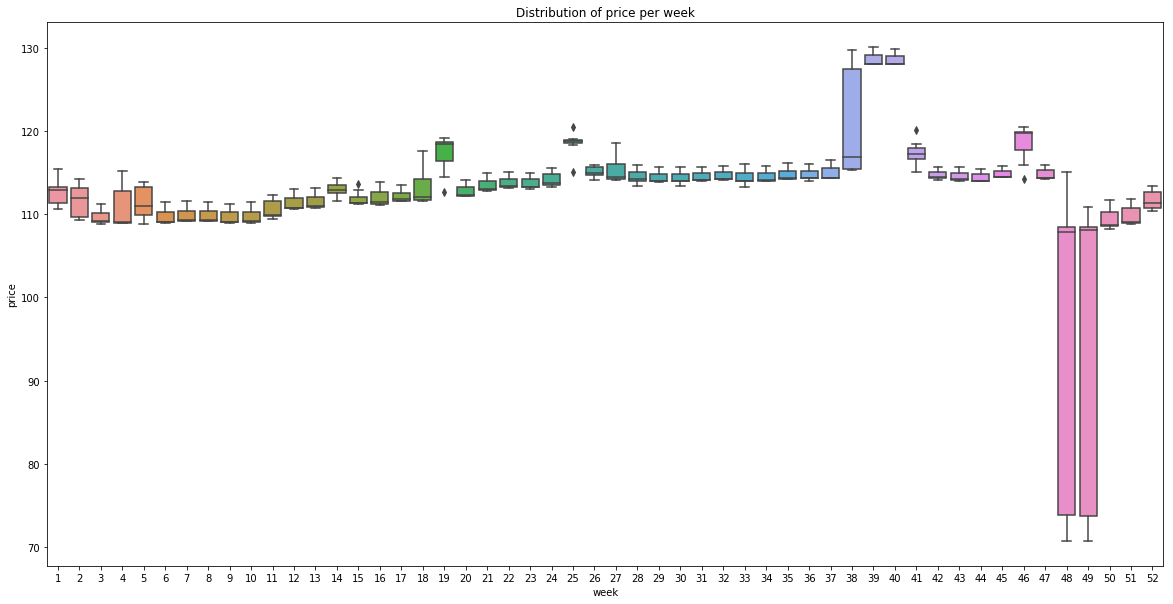

In [22]:
# Show a Boxplot to see the price distribution per week
plt.figure(figsize=(20, 10))
sns.boxplot(x = 'week',  y = 'price', data 
            = df_calendar_clean).set_title('Distribution of price per week');

**Summary for Question 1: "When is the most expensive time of the year to visit Munich and how much does the price spike?"**

Regardless of the location or other properties of the apartment, the following information results:
- **There are two periods in the year in which the price differs significantly.**  
    The mean price in the year is ~114 USD.  
    a) In weeks 39 and 40 the price increases on average by ~13% to ~129 USD. It looks like there is an Oktoberfest effect at Airbnb.  
    b)  In weeks 48 and 49 the price drops on average by 21% to ~94 USD. The drop in price is not obvious and requires additional research. 
- **The mean price rises slightly at the weekends (Friday and Saturday).**  
    During the week the mean price is around ~112 USD and on the weekend around ~114 USD; an increase of ~ 2%.   
- **The price of apartments also rises during cetrain times of the year.**  
    It is believed that both the german holidays and large exibitions could have an impact on this.  
    But this information cannot be obtained from the examined data set, and would needs additional analysis (e.g. in comparission with the holiday calendar)

**Answer:**  
The most expensive time of the year 2020 is between the end of September and the beginning of October during the Oktoberfest.
The mean price spikes around +15 USD.

**Preparation for Question 2 and 3: "What are the most expensive neighbourhoods in Munich?" and "What factors influence the price most?"**

In [23]:
# Copy the data to a new DataFrame for further clean up
df_listings_clean = df_listings.copy(deep=True)

In [24]:
# Clean up the data set "listings" as the previous analysis pointed out

# Drop features wich are not used further 
features_to_drop = ['listing_url', 'picture_url','host_url', 'host_thumbnail_url', 'host_picture_url',
                    'name', 'summary', 'space', 'neighborhood_overview', 'transit', 'interaction', 'description',
                    'host_name', 'host_location', 'host_neighbourhood', 'street', 'last_scraped', 'zipcode',
                    'calendar_last_scraped', 'first_review', 'last_review', 'host_since', 'calendar_updated',
                    'experiences_offered', 'state', 'country', 'country_code', 'city', 'market',
                    'host_total_listings_count', 'smart_location']
df_listings_clean.drop(features_to_drop, axis=1, inplace=True)

In [25]:
# Remove constant features by finding unique values per feature 
df_listings_clean = df_listings_clean[df_listings_clean.nunique().where(df_listings_clean.nunique()!=1).dropna().keys()]

# Drop features with 50% or more missing values
more_than_50 = list(df_listings_clean.columns[df_listings_clean.isnull().mean() > 0.5])
df_listings_clean.drop(more_than_50, axis=1, inplace=True)

# Clean up the format values. Maybe not the best solution - but will do the job.
df_listings_clean['price'] = df_listings_clean['price'].replace('[\$,]', '', regex=True).astype(float)
df_listings_clean['extra_people'] = df_listings_clean['extra_people'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df_listings_clean['cleaning_fee'] = df_listings_clean['cleaning_fee'].replace({'\$': '', ',': ''}, regex=True).astype(float)
        
# Convert rates type from string to float and remove the % sign
df_listings_clean['host_response_rate'] = df_listings_clean['host_response_rate'].str.replace('%', '').astype(float)
df_listings_clean['host_response_rate'] = df_listings_clean['host_response_rate'] * 0.01
    
# Covert boolean data from string data type to boolean
boolean_features = ['instant_bookable', 'require_guest_profile_picture', 
                'require_guest_phone_verification', 'is_location_exact', 'host_is_superhost', 'host_has_profile_pic', 
                'host_identity_verified']
df_listings_clean[boolean_features] = df_listings_clean[boolean_features].replace({'t': True, 'f': False})

## Fill numerical missing data with mean value
numerical_feature = df_listings_clean.select_dtypes(np.number)
numerical_columns = numerical_feature.columns

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean = imp_mean.fit(numerical_feature)

df_listings_clean[numerical_columns] = imp_mean.transform(df_listings_clean[numerical_columns])
     
# Remove all remaining missing values  
df_listings_clean.dropna(inplace=True)

In [26]:
# Show price statistic for each neighbourhood  
df_listings_clean.groupby(["neighbourhood_cleansed"])["price"].describe()

count        mean  \
neighbourhood_cleansed                                                  
Allach-Untermenzing                                  22.0  130.909091   
Altstadt-Lehel                                      158.0  167.082278   
Au-Haidhausen                                       296.0  119.472973   
Aubing-Lochhausen-Langwied                           42.0   91.166667   
Berg am Laim                                         83.0   97.891566   
Bogenhausen                                         196.0   99.295918   
Feldmoching-Hasenbergl                               50.0   97.440000   
Hadern                                               42.0   81.285714   
Laim                                                122.0   97.770492   
Ludwigsvorstadt-Isarvorstadt                        445.0  124.098876   
Maxvorstadt                                         403.0  123.923077   
Milbertshofen-Am Hart                               164.0   86.750000   
Moosach                                              82.0   91.134146   
Neuhausen-Nymphenburg                               281.0  111.199288   
Obergiesing                                         154.0  112.525974   
Pasing-Obermenzing                                   90.0  102.622222   
Ramersdorf-Perlach                                  209.0   81.717703   
Schwabing-Freimann                                  248.0   97.084677   
Schwabing-West                                      317.0  103.747634   
Schwanthalerhöhe                                    157.0  127.235669   
Sendling                                            172.0  104.139535   
Sendling-Westpark                                   180.0  112.561111   
Thalkirchen-Obersendling-Forstenried-Fürstenrie...  169.0  101.449704   
Tudering-Riem                                       152.0  141.894737   
Untergiesing-Harlaching                             132.0   99.636364   

                                                           std   min    25%  \
neighbourhood_cleansed                                                        
Allach-Untermenzing                                 141.315220  18.0  56.25   
Altstadt-Lehel                                      187.464781  39.0  82.75   
Au-Haidhausen                                       127.411063  18.0  60.00   
Aubing-Lochhausen-Langwied                           80.313081  16.0  35.00   
Berg am Laim                                         74.779189  25.0  50.50   
Bogenhausen                                          67.118144  15.0  54.50   
Feldmoching-Hasenbergl                               85.192018  26.0  45.00   
Hadern                                               50.591277  19.0  47.75   
Laim                                                 98.786671  20.0  40.00   
Ludwigsvorstadt-Isarvorstadt                         91.457907  28.0  69.00   
Maxvorstadt                                         113.091195   8.0  65.00   
Milbertshofen-Am Hart                                68.366154  20.0  45.00   
Moosach                                             106.684809  10.0  50.00   
Neuhausen-Nymphenburg                               114.292433  20.0  50.00   
Obergiesing                                         171.803817  25.0  45.00   
Pasing-Obermenzing                                  109.788927  21.0  40.00   
Ramersdorf-Perlach                                   62.855923  15.0  45.00   
Schwabing-Freimann                                   68.821227  10.0  55.00   
Schwabing-West                                       80.712214  18.0  55.00   
Schwanthalerhöhe                                    125.974618  25.0  69.00   
Sendling                                             76.657538  12.0  50.00   
Sendling-Westpark                                   115.406455  24.0  54.25   
Thalkirchen-Obersendling-Forstenried-Fürstenrie...  108.830958  14.0  50.00   
Tudering-Riem                                       202.367777  29.0  52.00   
Untergiesing-Harlaching   

In [27]:
# Create new feature 'mean' with the mean price per neighbourhood
df_listings_clean['mean']=df_listings_clean.groupby('neighbourhood_cleansed')['price'].transform(lambda r : r.mean())

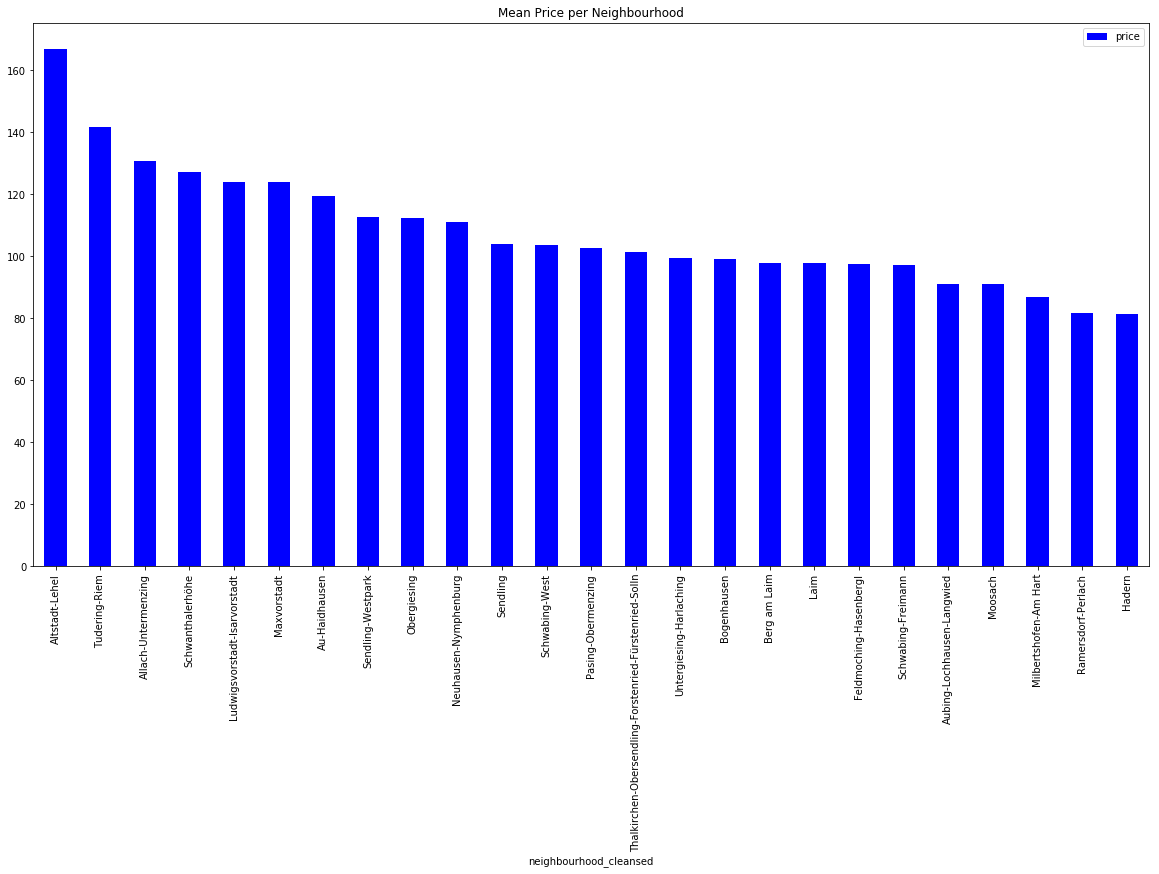

In [28]:
df_listings_plot = df_listings_clean
df_listings_plot = df_listings_plot.groupby('neighbourhood_cleansed')[['price']].mean()
df_listings_plot = df_listings_plot.reset_index()
df_listings_plot = df_listings_plot.sort_values(by='price',ascending=False)
df_listings_plot.plot.bar(x='neighbourhood_cleansed', y='price', color='blue', rot=90, figsize = (20,10)).set_title('Mean Price per Neighbourhood');

In [29]:
# Since we also have the geo data (latitude and longitude) of the apartments we can create a map
fig = px.scatter_mapbox(df_listings_clean, color="mean", lat='latitude', lon='longitude',
                        center=dict(lat=48.137154, lon=11.576124), zoom=10,
                        mapbox_style="stamen-terrain",width=1000, height=800);
fig.show()

**Summary for Question 2: "What are the most expensive neighbourhoods in Munich?"**

From the analysis, there is a clear difference in the costs between the different neighbourhoods in Munich.   
In general - the closer the apartment is to the city center or the Munich fair (Messe Munich), the higher the price.  
Furthermore the outliers must also be taken into account, since there are individual apartments in which the price deviates considerably.

**Answer:**  
The TOP 3 expensive neighbourhoods in Munich (average) are   
- Altstadt-Lehel 
- Trudering-Riem
- Allach-Untermenzing

........................

### Modeling - Encoding of the parameters for the ML model

In [30]:
# Copy the data to a new DataFrame for encoding 
df_listings_encoded = df_listings_clean.copy(deep=True)

In [31]:
# Show the remaining features and the data type
df_listings_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4366 entries, 5 to 11473
Data columns (total 58 columns):
id                                              4366 non-null float64
host_id                                         4366 non-null float64
host_response_time                              4366 non-null object
host_response_rate                              4366 non-null float64
host_is_superhost                               4366 non-null object
host_listings_count                             4366 non-null float64
host_verifications                              4366 non-null object
host_has_profile_pic                            4366 non-null object
host_identity_verified                          4366 non-null object
neighbourhood                                   4366 non-null object
neighbourhood_cleansed                          4366 non-null object
latitude                                        4366 non-null float64
longitude                                       4366 non-nu

In [32]:
# Remove outliers of the feature 'price" - drop all higher than 90% quantile
outliers = df_listings_encoded["price"].quantile(0.90)
df_listings_encoded = df_listings_encoded[df_listings_encoded["price"] < outliers]

In [33]:
# Encode features for use in machine learing model

# Encode feature 'amenities' and concat the data
df_listings_encoded.amenities = df_listings_encoded.amenities.str.replace('[{""}]', "")
df_amenities = df_listings_encoded.amenities.str.get_dummies(sep = ",")
df_listings_encoded = pd.concat([df_listings_encoded, df_amenities], axis=1) 

# Encode feature 'host_verification' and concat the data
df_listings_encoded.host_verifications = df_listings_encoded.host_verifications.str.replace("['']", "")
df_verification = df_listings_encoded.host_verifications.str.get_dummies(sep = ",")
df_listings_encoded = pd.concat([df_listings_encoded, df_verification], axis=1)
    
# Encode feature 'host_response_time'
dict_response_time = {'within an hour': 1, 'within a few hours': 2, 'within a day': 3, 'a few days or more': 4}
df_listings_encoded['host_response_time'] = df_listings_encoded['host_response_time'].map(dict_response_time)

# Encode the remaining categorical feature 
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'neighbourhood', 
                            'cancellation_policy']:
    df_listings_encoded = pd.concat([df_listings_encoded, 
                                     pd.get_dummies(df_listings_encoded[categorical_feature])],axis=1)
        
# Drop features
df_listings_encoded.drop(['amenities', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 
                          'host_verifications', 'neighbourhood','cancellation_policy','security_deposit',
                          'id', 'host_id', 'mean', 'latitude', 'longitude'],
                         axis=1, inplace=True)

In [34]:
# Last check if there are any missing values in the data set
sum(df_listings_encoded.isnull().sum())

0

In [35]:
# Shuffle the data to ensure a good distribution
df_listings_encoded = shuffle(df_listings_encoded)

X = df_listings_encoded.drop(['price'], axis=1)
y = df_listings_encoded['price']

# Split the data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [36]:
 # Initalize the model
model = RandomForestRegressor(max_depth=15, n_estimators=100, criterion='mse', random_state=42)
# Fit the model on training data
model.fit(X, y)
        
# Predict results
prediction = model.predict(X_test)

........................

### Evaluation - Check the created data model with the task

In [37]:
# Evaluate the result - compare r squared of the training set with the test set

# Find R^2 on training set
print("Training Set:")
print("R_squared:", round(model.score(X_train, y_train) ,2))

# Find R^2 on testing set
print("\nTest Set:")
print("R_squared:", round(model.score(X_test, y_test), 2))

Training Set:
R_squared: 0.88

Test Set:
R_squared: 0.88


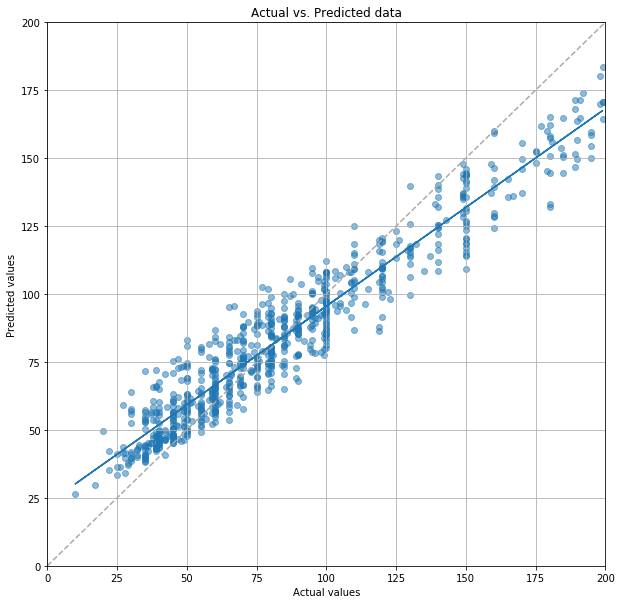

In [38]:
# Scatter plot of th actual vs predicted data
plt.figure(figsize=(10, 10))
plt.grid()
plt.xlim((0, 200))
plt.ylim((0, 200))
plt.plot([0,200],[0,200], color='#AAAAAA', linestyle='dashed')
plt.scatter(y_test, prediction, alpha=0.5)
coef = np.polyfit(y_test,prediction,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test, poly1d_fn(y_test))
plt.title('Actual vs. Predicted data');
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

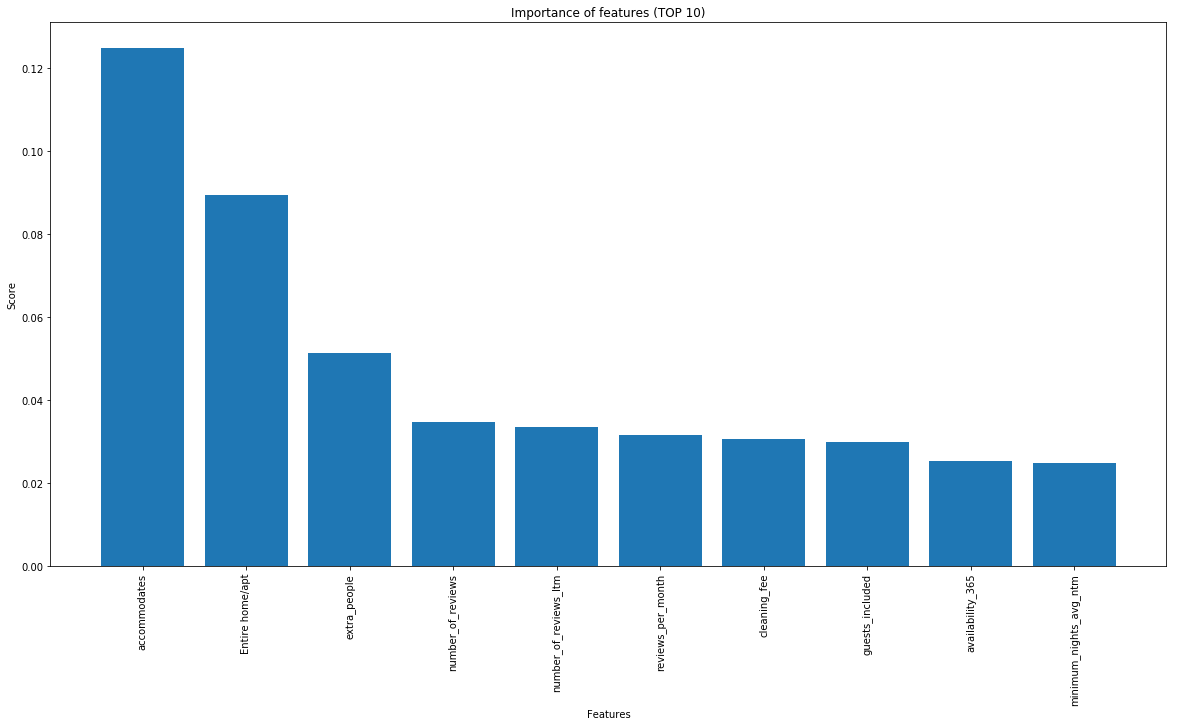

In [39]:
# Sort the importance of the features
importances = model.feature_importances_
    
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = ["feature", "score"])
feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

features = feature_importances['feature'][:10]
y_feature = np.arange(len(features))
score = feature_importances['score'][:10]

# Plot the importance of a feature to the price
plt.figure(figsize=(20,10));
plt.bar(y_feature, score, align='center');
plt.xticks(y_feature, features, rotation='vertical');
plt.xlabel('Features');
plt.ylabel('Score');
plt.title('Importance of features (TOP 10)');

**Summary for Question 3: "What factors influence the price most?"**

With a coefficient of determination (R^2) of 0.87, the model and the prediction seems accurate enough to predict the price of an apartment. Moreover, the coefficient of determination of the training data is the same.

**Answer:**  
The TOP 5 factors of an apartment that have the greatest influence on the price are:
- Accommodates
- Entire home/ Apartment
- Extra people
- Number of reviews
- Guests included

........................

### Summary and Conclusion

After analyzing the data, the questions can be answered as follows:

- The most expensive time of the year 2020 is between the end of September and the beginning of October during the Oktoberfest.
- The TOP 3 expensive neighbourhoods in Munich (in average) are:
    - Altstadt-Lehel
    - Trudering-Riem 
    - Allach-Untermenzing

- The TOP 5 factors of an apartment that have the greatest influence on the price are:
    - Accommodates
    - Entire home/ Apartment
    - Extra people
    - Number of reviews
    - Guest included

